In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import re

import os
import glob
import pdb

import matplotlib
from matplotlib import rc
from matplotlib import pyplot as plt
from cycler import cycler

from collections.abc import Mapping, Sequence

import json
import yaml


from dataclasses import dataclass, asdict

import tqdm

import IPython
from IPython.display import display

from io import StringIO

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# hueristic way to navigate one folder above the notebooks directory
if 'notebooks' in os.getcwd():
    os.chdir('..')
    
! pwd
print(1)    
#from train import Config
print(2)
#from vtab import VTAB_DATASET_NAMES, ADDITIONAL_DATASET_NAMES, DATASET_NAMES, SPECIALIZED_DATASET_NAMES, SPECIALIZED_DATASET_NAMES
print(3)

# host = !echo $HOST
# if 'c-0' in host[0]:
#     os.chdir(os.path.expanduser('~/expriment-starter'))
# else:
#     os.chdir('/Users/ycarmon/Drive/Research/DoG/vision_experiments')
    
# from src import Config

/specific/a/home/cc/students/cs/kreisler/open_lm_fork
1
2
3


# general utils

In [3]:
def modified_groupby(df, labels):
    if type(labels) == str:
        df.groupby(labels, dropna=False)

    if len(labels) == 0:
        return [("", df)]
    
    if len(labels) == 1:
        labels = labels[0]
    
    return df.groupby(labels, dropna=False)

In [4]:
def read_experiments(experiment_names, index_field='epoch', read_train=False, folder='results'):
    experiment_names = [os.path.join(folder, ename) for ename in experiment_names]
    paths_to_plot = [os.path.join(ename, fname) for ename in experiment_names 
                     for fname in os.listdir(ename) if not (fname.endswith('.yaml') or fname.endswith('.sh') or 'logs' in fname)] 
    short_names = paths_to_plot #[n.replace(experiment_name + '_', '') for n in folders_to_plot]
    # short_names

    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")

    train_dfs = {}
    eval_dfs = {}
    configs = {}
    for folder_name, short_name in tqdm.tqdm(list(zip(paths_to_plot, short_names))):
        is_done = os.path.exists(os.path.join(folder_name, 'done'))

        eval_path = os.path.join(folder_name, 'stats_eval.csv')
        eval_path_tmp = os.path.join(folder_name, 'stats_eval_tmp.csv')
        with open(eval_path, 'r') as f:
            csv_text = f.read()
        if csv_text[0] != ',':
            print(short_name)
            continue
        csv_text = csv_text.replace(',[',',"[')
        csv_text = csv_text.replace('],',']",')
        csv_text = csv_text.replace('[ ','[')
        csv_text = csv_text.replace(' ]',']')
        csv_text = csv_text.replace('. ','.0')
        csv_text = ' '.join(csv_text.split(sep=' '))
        with open(eval_path_tmp, 'w') as f:
            f.write(csv_text)
        try:
            df = pd.read_csv(eval_path_tmp)#(StringIO(csv_text))#(eval_path)
        except:
            continue
        
        with open(os.path.join(folder_name, 'args.yaml'), 'r') as f:
            configs[short_name] = yaml.safe_load(f) # asdict(Config(**yaml.safe_load(f)))
    #     df['name'] = short_name
        configs[short_name]['is_done'] = is_done
        if not 'loss' in configs[short_name]:
            configs[short_name]['loss'] = 'none'

        
        df = df.rename(columns={'Unnamed: 0': 'epoch'}).rename(columns=lambda x: x.replace('eval/', 'test/'))
        #print(short_name, len(df.columns), df.columns)
        df['epoch'] += 1

        assert(index_field != 'step')
        #df['step'] = df['train/seen_examples'] / configs[short_name]['batch_size']
        
        if read_train:
            assert(False)
            train_df = pd.read_csv(os.path.join(folder_name, 'stats_train.csv'))
            train_df = train_df.rename(columns={'Unnamed: 0': 'step'})
            train_df['step'] = (train_df['step'] + 1) / configs[short_name]['grad_accum_steps']
            train_df['epoch'] = ((train_df['seen_examples'] - 1) / df.iloc[0]['train/seen_examples']).astype(int)
            train_df = train_df[ train_df['seen_examples'] % configs[short_name]['batch_size'] == 0 ]
            train_df = train_df.set_index(index_field)
            train_dfs[short_name] = train_df
        
        if os.path.exists(os.path.join(folder_name, 'stats_regret.csv')):
            regret_df = pd.read_csv(os.path.join(folder_name, 'stats_regret.csv')).set_index('epoch')
            regret_df['regret_ratio'] = regret_df.regret / regret_df.loss_diff
            regret_df = pd.concat([split_df.rename(columns=lambda x: split + '/' + x) for split, split_df in modified_groupby(regret_df,'split')], axis=1)
            df = pd.concat([df.set_index('epoch'), regret_df], axis=1).reset_index()
        
        df = df.set_index(index_field)
        eval_dfs[short_name] = df
        # eval_dfs[short_name] = eval_dfs[short_name].rename(columns=lambda n: n.replace('accuracy_av', 'accuracy/average'))
    #     train_dfs[short_name] = modified_groupby(pd.read_csv(os.path.join(experiment_name, folder_name, 'stats_train.csv')),'epoch').mean()
        

    print('Successfully read %d out of %d folders' % (len(eval_dfs) ,len(paths_to_plot)))

    keys = set([c for df in eval_dfs.values() for c in df.columns])  # remove 

    # turn every run into a "row" in a dataframe that also contains the entire config
    big_df = pd.DataFrame(configs).T.rename_axis('name').sort_index()
    for key in keys:
        big_df[key] = [eval_dfs[name][key] if key in eval_dfs[name].columns else np.array([]) for name in big_df.index]
        
    if read_train:
        keys = set([c for df in train_dfs.values() for c in df.columns])
        for key in keys:
            big_df['training/' + key] = [train_dfs[name][key] if key in train_dfs[name].columns else np.array([]) for name in big_df.index]

#     # throw away stuff that didn't finish running
# #     valid_mask = big_df.epochs == big_df['test/robust_loss'].apply(len)
#     valid_mask = big_df['eval/loss'].apply(len) > 0 # == big_df['eval_num']
#     big_df = big_df[valid_mask]
#     config_df = pd.DataFrame(configs).T.rename_axis('name').sort_index()[valid_mask]
# #     config_df['ada_eps'].fillna(1e-8, inplace=True)

    print('%d results left after filtering' % (len(big_df),))
    
#     big_df.loc[big_df['training_examples'] < 0, 'training_examples'] = np.inf

    return big_df

@dataclass
class Interval:
    start: float = -np.inf
    end: float = np.inf

def filt(df, **kwargs):
    filt_df = df.copy()
    for k, v in kwargs.items():
        if callable(v):
            filt_df = filt_df.loc[filt_df[k].apply(v)]
        elif isinstance(v, str):
            if v.startswith('~'):
                filt_df = filt_df.loc[~filt_df[k].str.contains(v[1:])]
            else:
                filt_df = filt_df.loc[filt_df[k].str.contains(v)]
        elif isinstance(v, tuple):
            for vv in v:
                filt_df = filt(filt_df, **{k: vv})
        elif isinstance(v, list):
            filt_df = pd.concat([filt(filt_df, **{k: vv}) for vv in v], axis=0)
        elif isinstance(v, float) or isinstance(v, int) or isinstance(v, bool):
            filt_df = filt_df.loc[filt_df[k]==v]
        elif isinstance(v, Interval):
            filt_df = filt_df[(v.start <= filt_df[k]) & (filt_df[k] <= v.end)]
        else:
          raise ValueError(f'Don''t know how to handle filter type {type(v)}')
    return filt_df

def pick_best(df, index_columns, target_column, k_best=1, horizon=np.inf): 
    df = df.copy()
    
    if 'loss' in target_column:
        op = lambda x: -x.truncate(after=horizon).min()
    else:
        op = lambda x: x.truncate(after=horizon).max()

    df['target'] = df[target_column].apply(op)

    if len(index_columns)  > 0:
        df = df.reset_index().set_index(index_columns).sort_index()
        best_rows = pd.DataFrame()
        for i in df.index.unique():
            best_rows = best_rows.append(df.loc[[i]].nlargest(k_best, 'target'))
    else:
        best_rows = df.nlargest(k_best, 'target')
    
#     pdb.set_trace()
    return best_rows.reset_index().set_index('name')

def nanfloat(x):
    try:
        return float(x)
    except:
        return np.nan
    
def nice_string(s):
    return s.replace('_', ' ').capitalize()

def short_string(s, strlen=12):
    return '_'.join([ss[:strlen] for ss in s.split('_')])

def config_str(ks, vs, key_len=12, sep=', '):
    if not isinstance(vs, tuple) or isinstance(vs, list):
        vs = [vs]
    return sep.join([f'{short_string(k, strlen=key_len)} = {v}' for k, v in zip(ks, vs)])

MARKERS = ['o', 'v', 'p', 'X', '<', 's', '^','P', '*', '>', 'd']
LINESTYLES = ['-', '--', ':', '-.']
COLORS = [c for c in matplotlib.colors.TABLEAU_COLORS]#[:-2]

def get_marker(i):
    return MARKERS[i % len(MARKERS)]

def get_color(i, clist=None):
    if clist is None:
        clist = COLORS
    return clist[i % len(clist)]

def get_linestyle(i):
    return LINESTYLES[i % len(LINESTYLES)]

In [5]:
folders = np.sort(os.listdir('results'))
folders_quotes = [f"'{f}'" for f in folders]
print(f'[{", ".join(folders_quotes)}]')

['24-05-08-openhermes_adam_betas', '24-05-09-openhermes_dog_6layers_decay_to_init']


# DoG

In [6]:
def clean_nanmin(arr):
    if len(arr) == 0 or np.all(np.isnan(arr)):
        return np.nan
    return np.nanmin(arr)

def clean_nanmax(arr):
    if len(arr) == 0 or np.all(np.isnan(arr)):
        return np.nan
    return np.nanmax(arr)

In [7]:
def init_dist_to_rbar(dist):
    if isinstance(dist, float):
        return dist
    elif isinstance(dist, str):
        dist_arr = np.fromstring(dist[1:-1], dtype=np.float64, sep=' ')
        return np.linalg.norm(dist_arr)
    raise  Exception('dist of unknown type ' + str(type(dist)))

def generate_dog_data_partial(df):
    accele_df = df.query('optim_alg != "dog" and optim_alg != "dog_public"').copy()
    accele_df.loc[:,'train/effective_lr'] = accele_df.loc[:,'train/alpha'] * accele_df.loc[:,'train/eta']

    return accele_df

def generate_dog_data(df, with_effective_lr = True):
    dog_df = df.query('optim_alg == "dog" or optim_alg == "dog_public"').copy()
    accele_df = df.query('optim_alg != "dog" and optim_alg != "dog_public"').copy()

    dog_df.loc[:,'train/rbar'] = dog_df.loc[:,'train/dog/init_dist'].map( lambda x: x.map( lambda y: init_dist_to_rbar(y)))
    dog_df.loc[:,'train/alpha'] = dog_df.loc[:,'train/dog/init_dist'].map( lambda x: x.map( lambda y: 1.))
    dog_df.loc[:,'train/eta'] = dog_df.loc[:,'train/dog/eta']

    accele_df.loc[:,'train/rbar'] = accele_df.loc[:,'train/rbar'].map( lambda x: x.map( lambda y: init_dist_to_rbar(y)))

    new_df = pd.concat([dog_df, accele_df])
    if with_effective_lr:
        new_df.loc[:,'train/effective_lr'] = new_df.loc[:,'train/alpha'] * new_df.loc[:,'train/eta']

    return new_df

def get_best_losses(*dfs):
    best_losses = {}

    for df in dfs:
        for loss in df['loss'].unique():
            best_loss = clean_nanmin( df.query(f'loss == "{loss}"').filter(regex='.*/loss').applymap( clean_nanmin ).values )
            best_losses[loss] = clean_nanmin( [best_loss, best_losses.get(loss, np.inf)] )

    return best_losses

def generate_subopt_helper(df, best_loss):
    best_loss = clean_nanmin( df.filter(regex='.*/loss').applymap( clean_nanmin ).values )
    for key in df.filter(regex='.*/loss').columns:
        subopt_key = key[:-4] + "empirical_subopt"
        df.loc[:,subopt_key] = df.loc[:,key] - best_loss

    return df

def generate_subopt(df, best_losses: dict = None):

    if best_losses is None:
        best_losses = get_best_losses(df)

    new_dfs = []
    for loss in df['loss'].unique():
        new_df = df.query(f'loss == "{loss}"').copy()
        new_df = generate_subopt_helper(new_df, best_losses[loss])
        new_dfs.append(new_df)


    new_df = pd.concat(new_dfs)
    return new_df

In [8]:
def sgd_find_best(df, field='train/empirical_subopt', method = "best"):
    row_fields = ['model', 'dataset', 'batch_size', 'loss', 'momentum', 'activation']
    legend_fields = ['base_lr']

    best_func = clean_nanmin
    best_value_init = np.inf
    if 'accuracy' in field:
        best_func = clean_nanmax
        best_value_init = -np.inf

    arr_best = lambda arr: arr.iloc[-1]
    if method == "best":
        arr_best = lambda arr: best_func(arr)

    rows = []
    count=0
    #df['is_best'] = df['dog_granularity'].map( lambda y: False)
    for i_row, (row_vals, row_df) in enumerate(modified_groupby(df, row_fields)):

        best_value = best_value_init
        # Finding the best value
        for i_entry, (legend_vals, entry_df) in enumerate(modified_groupby(row_df,legend_fields)):
            assert(len(entry_df[field]) == 1)
            current_best_value = arr_best(entry_df[field][0])
            
            if not np.isnan(current_best_value):
                if best_value is None:
                    best_value = current_best_value
                best_value = best_func([best_value, current_best_value])

        # Add correct entry
        found = False
        for i_entry, (legend_vals, entry_df) in enumerate(modified_groupby(row_df,legend_fields)):
            last_epoch = len(entry_df[field][0])
            current_best_value = arr_best(entry_df[field][0])
            if (best_value == current_best_value):
                rows.append(entry_df)

    return pd.concat(rows)#.query('is_best')

In [9]:
def limit_series(x, limit):
    if limit is None or limit <= 0 or isinstance(x, (np.floating,float)):
        return x
    return x[:limit] if isinstance(x, np.ndarray) else x.truncate(after=limit)

def create_last_and_best(df, limit=None):
    for keyword in ['loss', 'empirical_subopt', 'accuracy']:
        for key in df.filter(regex='.*/'+keyword).columns:

            is_float_or_empty = lambda x: isinstance(x, (np.floating,float)) or len(x) == 0

            # Last
            key_last = key[:-len(keyword)] + 'last_' + keyword
            df.loc[:,key_last] = df.loc[:,key].map( lambda x: np.nan if is_float_or_empty(limit_series(x, limit)) else limit_series(x, limit).iloc[-1] )

            # Best
            best_func = clean_nanmin
            if keyword == 'accuracy':
                best_func = clean_nanmax
            key_best = key[:-len(keyword)] + 'best_' + keyword
            df.loc[:,key_best] = df.loc[:,key].map( lambda x: np.nan if is_float_or_empty(limit_series(x, limit)) else best_func(limit_series(x, limit)) )

    return df

In [10]:
def select_av(df, av='constant_8'):
    df = df

    for col in df.filter(regex='.*/'+ av + '/.*').columns:
        av_col = col.replace('/'+ av + '/', '/av/')
        df[av_col] = df[col]

    return df

# Table  Utils

In [11]:
def get_best_value(df, fields, y_field, use_max=True):
    best_func = clean_nanmax if use_max else clean_nanmin
    worst_func = clean_nanmin if use_max else clean_nanmax

    best_dict = {}
    initial_dict = {}
    for i_row, (row_vals, row_df) in enumerate(modified_groupby(df,fields)):
        key =str(row_vals)
        best_dict[key] = best_func( row_df.loc[:,y_field].apply( best_func ).values )
        initial_dict[key] = worst_func( row_df.loc[:,y_field].apply( lambda x: x.iloc[0] ).values )

    return best_dict, initial_dict

def get_number_of_steps_until(df, fields, col_fields, y_field, best_dict, until, use_max=True, initial_dict=None):
    
    dfs_arr = []
    dfs_dict = {}
    key_to_vals = {}
    for i_row, (row_vals, row_df) in enumerate(modified_groupby(df,fields)):
        key = str(row_vals)
        key_to_vals[key] = row_vals
        if initial_dict is None:
            until_value = best_dict[key] * until
        else:
            assert use_max
            until_value = (best_dict[key] - initial_dict[key]) * until + initial_dict[key]
        df_copy = row_df.copy()

        from_where = df_copy.loc[:,y_field].apply( lambda x: x.apply( lambda y: (-np.inf if use_max else np.inf) if np.isnan(y) else y ) )
        from_where = from_where.apply( lambda x: x>= until_value if use_max else x<= until_value )
        from_where = from_where.apply( lambda x: x.idxmax() if x.max() else np.inf, axis='columns' )
        df_copy.loc[:,'steps_until'] = from_where
        dfs_arr.append(df_copy)

        tmp_dict = {}
        for n in df_copy.index:
            tmp_dict[n] = str(df_copy.loc[n,col_fields].values)

        dfs_dict[key] = from_where.rename( tmp_dict )
    
    new_table = pd.DataFrame.from_dict(dfs_dict, 'index')
    for key in key_to_vals:
        new_table.loc[key, fields] = key_to_vals[key]
        #for feild, val in zip(fields, key_to_vals[key]):
        #    new_table.loc[key, feild] = val

    new_table = new_table.set_index(fields)

    return new_table # pd.concat( dfs_arr ),

In [12]:
def get_best_accuracy_val(sr, limit=None):
    last_is_better = sr['val/last/accuracy'] > sr['val/av/accuracy']
    best_val_acc = sr['val/last/accuracy'].where(last_is_better, sr['val/av/accuracy'])
    best_test_acc = sr['test/last/accuracy'].where(last_is_better, sr['test/av/accuracy'])
    if limit:
        best_val_acc[:limit]
    idx = best_val_acc.idxmax()

    return best_test_acc[idx]

def get_best_accuracy(sr, limit=None):
    last_is_better = sr['test/last/accuracy'] > sr['test/av/accuracy']
    best_test_acc = sr['test/last/accuracy'].where(last_is_better, sr['test/av/accuracy'])

    if limit:
        return best_test_acc[:limit].max()
    return best_test_acc.max()

In [13]:
def get_best_loss_val(sr, limit=None):
    last_is_better = sr['val/last/loss'] > sr['val/av/loss']
    best_val_acc = sr['val/last/loss'].where(last_is_better, sr['val/av/loss'])
    best_test_acc = sr['test/last/loss'].where(last_is_better, sr['test/av/loss'])
    if limit:
        best_val_acc[:limit]
    idx = best_val_acc.idxmin()

    return best_test_acc[idx]

def get_best_test_loss(sr, limit=None):
    last_is_better = sr['test/last/loss'] > sr['test/av/loss']
    best_test_acc = sr['test/last/loss'].where(last_is_better, sr['test/av/loss'])

    if limit:
        return best_test_acc[:limit].min()
    return best_test_acc.min()


def get_best_train_loss(sr, limit=None):
    best_test_acc = sr['train/loss']

    if limit:
        return best_test_acc[:limit].min()
    return best_test_acc.min()

In [38]:
def get_test_loss_tables(df, rows='optim_alg', val=False, limit=None):
    df = df.copy()
    if val:
        df['test/best/loss'] = df.apply(get_best_loss_val, args=(limit,), axis=1)
    else:
        df['test/best/loss'] = df.apply(get_best_test_loss, args=(limit,), axis=1)

    models_names = []
    for i_row, (row_vals, row_df) in enumerate(modified_groupby(df,['model'])):
        models_names.append(row_vals)

    tables = {}
    for model_name in models_names:
        model_df = df.query(f'model == "{model_name}"')

        new_df = {}
        for i_row, (row_vals, row_df) in enumerate(modified_groupby(model_df,rows)):
            new_df[row_vals] = row_df['test/best/loss'].copy()
            new_df[row_vals] = new_df[row_vals].rename(row_df['wd'])
        tables[model_name] = pd.DataFrame.from_dict(new_df, 'index')
    return tables

In [15]:
def get_train_loss_tables(df, rows='optim_alg', limit=None):
    df = df.copy()
    df['train/best/loss'] = df.apply(get_best_train_loss, args=(limit,), axis=1)

    models_names = []
    for i_row, (row_vals, row_df) in enumerate(modified_groupby(df,['model'])):
        models_names.append(row_vals)

    tables = {}
    for model_name in models_names:
        model_df = df.query(f'model == "{model_name}"')

        new_df = {}
        for i_row, (row_vals, row_df) in enumerate(modified_groupby(model_df,rows)):
            new_df[row_vals] = row_df['train/best/loss'].copy()
            new_df[row_vals] = new_df[row_vals].rename(row_df['wd'])
        tables[model_name] = pd.DataFrame.from_dict(new_df, 'index')
    return tables

# UniXGrad

In [ ]:
markers = {'unixgrad': '+', 'accele_dog': '*', 'uni_dog': 's', 'dog_public': 'o', 'accelegrad': 'p'} 
colors = {'unixgrad': 'blue', 'accele_dog': 'orange', 'uni_dog': 'purple', 'dog_public': 'red', 'accelegrad': 'tab:purple'}
colors_bounded = {'unixgrad': {"True": 'blue', "False": 'cyan'}, 'accelegrad': {"True": 'tab:purple', "False": 'tab:pink'}}
nice_names = {'unixgrad': 'UniXGrad', 'accele_dog': 'A-DoG', 'uni_dog': 'U-DoG', 'dog_public': 'DoG', 'accelegrad': 'AcceleGrad'}
names_order = ['accele_dog', 'uni_dog', 'dog_public', 'unixgrad', 'accelegrad']
marker_size=7

import matplotlib.colors as mcolors

cmap = plt.cm.viridis
def transform(val):
    return -np.log10(1 - val)
norm = mcolors.Normalize(vmin=transform(0), vmax=transform(0.9999))

def make_sensitivity_plots(big_df_filt, epoch_selection = 'last', max_epoch_vals = [100, 400, 1000, 4000, 10000, 20000], 
                           rowsplit_keys = ['batch_size'], x_axis = 'diameter', y_axis = 'test/constant_8/accuracy', baseline_alg_mask = f'optim_alg in ("unixgrad", "accelegrad")',
                           baseline_alg_split_keys = ['optim_alg', 'bounded'], auto_y_lim_range = 0.05, y_lim = [0.8, 0.95],
                           proposed_alg_mask = f'optim_alg.str.contains("dog")', proposed_alg_split_keys = ['optim_alg'], fig=None, axes=None, colorbar=False):
    pretty_mode = False
    x_axis_categorical = False
  
    nrows = 1
    ncols = len(max_epoch_vals)
    assert not ((fig is None) ^ (axes is None))
    create_legend = fig is None
    
        
    for rowsplit_vals, row_df in big_df_filt.groupby(rowsplit_keys):
        hlines = []

        baseline_alg_df = row_df.query(baseline_alg_mask)
        proposed_alg_df = row_df.query(proposed_alg_mask)
        
        if len(baseline_alg_df) == 0:
            continue
    
        base_size = (7, 7) if not pretty_mode else (4, 4)
        if fig is None:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(base_size[0] * ncols, base_size[1] * nrows), facecolor='w', sharey='row')
        if nrows * ncols == 1:
            axes = np.array(axes)
        axes = axes.reshape(nrows, ncols)
    
        for j, max_epoch in enumerate(max_epoch_vals):
            plt.sca(axes[0, j])
            axes[0, j].clear()
            
            if len(baseline_alg_df[y_axis].iloc[0].truncate(after=max_epoch)) == 0:
                continue
                
            baselines_to_plot = {}
            
            for i, (baseline_split_vals, baseline_split_df) in enumerate(baseline_alg_df.groupby(baseline_alg_split_keys, dropna=False)):
                if epoch_selection == 'best':
                    baseline_split_df['selected_y'] = baseline_split_df[y_axis].apply(lambda x: x.truncate(after=max_epoch).max())
                elif epoch_selection == 'last':
                    baseline_split_df['selected_y'] = baseline_split_df[y_axis].apply(lambda x: x.truncate(after=max_epoch).iloc[-1])
                else:
                    raise ValueError('?')
                to_plot = baseline_split_df.groupby(x_axis, dropna=False)['selected_y'].max()
                if x_axis_categorical:
                    # to_plot.index = to_plot.index.fillna('none')
                    to_plot.index = pd.Categorical(to_plot.index.values) #, categories=sorted(baseline_alg_df[x_axis].unique()))
                # pdb.set_trace()
            
                baselines_to_plot[config_str(baseline_alg_split_keys, baseline_split_vals)] = to_plot
                
            baselines_to_plot = pd.DataFrame(baselines_to_plot)
            baselines_to_plot.index = baselines_to_plot.index.fillna('none')
            # styles = [dict(color=get_color(i), marker=get_marker(i)) for i in range(len(baselines_to_plot))]
            # styles = [get_color(i) for i in range(len(baselines_to_plot))]
            h = baselines_to_plot.plot(ax=plt.gca(), legend=False, ms=marker_size)
            for i, ln in enumerate(h.lines):
                ln.set_marker(get_marker(i))
                # ln.set_color(get_color(i))
                #momentum = float(baselines_to_plot.columns[i].split('momentum = ')[-1])
                # pdb.set_trace()
                #ln.set_color(get_momentum_color(momentum))
                opt_alg = baselines_to_plot.columns[i].split(', ')[0].split('optim_alg = ')[-1]
                bounded = baselines_to_plot.columns[i].split(', ')[1].split('bounded = ')[-1]
                ln.set_color(colors_bounded[opt_alg][bounded])
    
            for ii, (proposed_split_vals, proposed_split_df) in enumerate(proposed_alg_df.groupby(proposed_alg_split_keys, dropna=False)):
                if epoch_selection == 'best':
                    proposed_split_df['selected_y'] = proposed_split_df[y_axis].apply(lambda x: x.truncate(after=max_epoch).max())
                elif epoch_selection == 'last':
                    proposed_split_df['selected_y'] = proposed_split_df[y_axis].apply(lambda x: x.truncate(after=max_epoch).iloc[-1])
                else:
                    raise ValueError('?')
                to_plot = proposed_split_df['selected_y'].max()

                # pdb.set_trace()
                if len(proposed_split_vals) > 1 or proposed_split_vals[0] not in colors:
                    color = colors.get(baseline_split_vals, get_color(-1-ii))
                    plt.axhline(to_plot, color=color, ls='--', lw=2, label=f'{config_str(proposed_alg_split_keys, proposed_split_vals)}')
                else:
                    color = colors[proposed_split_vals[0]]
                    marker = markers[proposed_split_vals[0]]
                    hlines.append((color, marker, to_plot))
                    plt.axhline(to_plot, color=color, lw=2, label=f'{config_str(proposed_alg_split_keys, proposed_split_vals)}')

    
            plt.title(f'Max {baseline_alg_df[y_axis].iloc[0].index.name} = {max_epoch}')
            if not x_axis_categorical:
                plt.xscale('log')
            if y_lim == 'auto':
                # y_max = min(1.0, pd.concat([baseline_alg_df, proposed_alg_df], axis=0)[y_axis].apply(lambda x: x.max()).max() + auto_y_lim_range)
                # y_min = min(0.0, pd.concat([baseline_alg_df, proposed_alg_df], axis=0)[y_axis].apply(lambda x: x.min()).min() - auto_y_lim_range)
                y_max = min(1.0, np.nanpercentile(pd.concat([baseline_alg_df, proposed_alg_df], axis=0)[y_axis].apply(lambda x: x.max()), 95) + auto_y_lim_range)
                y_min = max(0.0, np.nanpercentile(pd.concat([baseline_alg_df, proposed_alg_df], axis=0)[y_axis].apply(lambda x: x.min()), 5) - auto_y_lim_range)
                #plt.ylim(y_min, y_max)
            else:    
                plt.ylim(y_lim)
            if 'loss' in y_axis or 'subopt' in y_axis or 'rbar' in y_axis:
                plt.yscale('log')
            plt.ylabel(y_axis)
            plt.xlabel(x_axis)
    
            plt.grid(True, which='major', axis='y')
            if not x_axis_categorical:
                plt.grid(True, which='major', axis='x')
            plt.grid(True, which='minor', axis='y', color=[0.9, 0.9, 0.9], linestyle='--')
    
    
        handles, labels = plt.gca().get_legend_handles_labels()
    
        if create_legend:
            fig.legend(
                    prop={"size": 14},
            #         columnspacing=0.0,
                    ncol=5,
                    handles=handles,
                    labels=labels,
                    loc='lower center',
                    bbox_to_anchor=[0.5, -0.125],
                    frameon=True,
                    markerscale=1.0,
                )
            dataset_name = big_df_filt.iloc[0].dataset.replace('/', '+')
            model_name = big_df_filt.iloc[0].model.replace('/', '+')
            
            fig.suptitle(f'{dataset_name} {config_str(rowsplit_keys, rowsplit_vals)}')
        
            plt.tight_layout()
            plt.show()
            filename = f"figs/sensitivity/{dataset_name}-{config_str(rowsplit_keys, rowsplit_vals)} {model_name} sensitivity.pdf"
            #fig.savefig(filename, dpi=300, bbox_inches='tight')
            #fig.savefig(filename.replace('pdf', 'png'), dpi=300, bbox_inches='tight')
        else:
            metric = y_axis.replace('constant_8/', '').replace('/', ' ')
            plt.gca().set_title(f'{metric.capitalize()} after {max_epoch_vals[0]} batches')
            plt.xlabel('learning rate')

            if colorbar:
                # Create a color bar with the transformed scale
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=plt.gca())
                # Set the color bar labels to the original real values
                cbar.set_ticks(transformed_momentum_values)
                cbar.set_ticklabels([f'{val:.4f}' for val in momentum_values])
                cbar.set_label('Momentum')

            x_min, x_max = plt.gca().get_xlim()
            # Plot a single marker at the rightmost edge
            for color, marker, to_plot in hlines:
                plt.gca().plot(10**-5, to_plot, marker=marker, color=color, markersize=marker_size)

In [ ]:
dog_df = read_experiments(['/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-convex_clevr_distance',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-convex_dmlab',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-convex_pendigits',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-convex_resisc45',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-convex_sun397',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-convex_ls_svhn_vit',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-04-imagenet-vit_b32-20-40',

                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-convex_clevr_distance',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-convex_dmlab',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-convex_pendigits',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-convex_resisc45',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-convex_sun397',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-convex_ls_svhn_vit',
                        '/a/home/cc/students/cs/kreisler/dog/vision_experiments/paper_results/24-04-15-imagenet-vit_b32-0.2-10',

                        '/specific/netapp5/joberant/home/maorivgi/code/dog/vision_experiments/paper_results/24-01-22-convex_clevr_distance',
                        '/specific/netapp5/joberant/home/maorivgi/code/dog/vision_experiments/paper_results/24-01-22-convex_dmlab',
                        '/home/ycarmon/no_backup/users/ycarmon/adog/paper_results/24-01-23-convex_pendigits', 
                        '/home/ycarmon/no_backup/users/ycarmon/adog/paper_results/24-01-23-convex_pendigits_more_bss',  
                        '/specific/netapp5/joberant/home/maorivgi/code/dog/vision_experiments/paper_results/24-01-21-convex_resisc45',
                        '/specific/netapp5/joberant/home/maorivgi/code/dog/vision_experiments/paper_results/24-01-21-convex_sun397',
                        '/home/ycarmon/no_backup/users/kreisler/accelerated_dog/paper_results/24-03-26-convex_ls_svhn_vit',
                        '/home/ycarmon/no_backup/users/ycarmon/adog/paper_results/24-01-24-imagenet-vit_b32'
      #'23-10-18-vtab-accelerate-dog-test'
                                #'23-09-13-linear_cifar100_resnet50', '23-09-13-linear_cifar100_vit_base_patch32_224_in21k',
                                #'23-09-13-linear_clevr_distance_resnet50', '23-09-13-linear_clevr_distance_vit_base_patch32_224_in21k',
                                #'23-09-13-linear_dsprites_ori_resnet50', '23-09-13-linear_dsprites_ori_vit_base_patch32_224_in21k',
                                #'23-09-13-linear_svhn_resnet50', '23-09-13-linear_svhn_vit_base_patch32_224_in21k'
                          ])#, index_field='step')
dog_df = dog_df.query('optim_alg == "dog" or optim_alg == "dog_public" or optim_alg == "uni_dog" or optim_alg == "accele_dog" or optim_alg == "unixgrad" or optim_alg == "accelegrad"')
dog_df = generate_subopt(dog_df)
dog_df = generate_dog_data(dog_df)

In [ ]:
dog_df['dataset'].unique()

In [ ]:
filtered_df = dog_df.query('dataset == "wds/imagenet"')

In [ ]:
filtered_df['batch_size'].unique()

In [ ]:
filtered_df = filtered_df.query('batch_size == 32 or batch_size == 512 or batch_size == 8192 or batch_size == 128')
# .query('batch_size == 4 or batch_size == 256 or batch_size == 16384')

In [ ]:
filtered_df['batch_size'].unique()

In [ ]:
batch_df = filtered_df#.query('batch_size == 4096')
make_sensitivity_plots(batch_df, max_epoch_vals=[5, 20, 100], y_lim='auto')  #[100, 400, 1000] #[1000, 10000, 50000]

In [ ]:
batch_df = filtered_df.copy()#.query('batch_size == 4096')
best = np.nanmin(batch_df['train/loss'].apply(np.nanmin))
batch_df['train/loss'] -= best
make_sensitivity_plots(batch_df, max_epoch_vals=[5, 20, 100], y_lim=[1e-1,10.], y_axis='train/loss') # [1000, 10000, 50000] # [100, 400, 1000] #'auto'

In [ ]:
batch_df = filtered_df.copy()#.query('batch_size == 4096')
best = np.nanmin(batch_df['train/loss'].apply(np.nanmin))
batch_df['train/loss'] -= best
make_sensitivity_plots(batch_df, max_epoch_vals=[1, 20, 100], y_lim='auto', y_axis='train/rbar') # [1000, 10000, 50000] # [100, 400, 1000] #'auto'

# openhermes dog

In [16]:
conv_big_df = read_experiments(['24-05-09-openhermes_dog_6layers_decay_to_init'
                          ], index_field='epoch', folder='results')

100%|██████████| 84/84 [00:13<00:00,  6.08it/s]


Successfully read 84 out of 84 folders
84 results left after filtering


In [17]:
conv_big_df = generate_subopt(conv_big_df)

/tmp/ipykernel_3227649/3226964341.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  best_loss = clean_nanmin( df.query(f'loss == "{loss}"').filter(regex='.*/loss').applymap( clean_nanmin ).values )
/tmp/ipykernel_3227649/3226964341.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  best_loss = clean_nanmin( df.filter(regex='.*/loss').applymap( clean_nanmin ).values )


In [31]:
conv_big_df = select_av(conv_big_df, 'poly_32_1')

In [32]:
by_steps = False
limit = None #7000 #

7 3


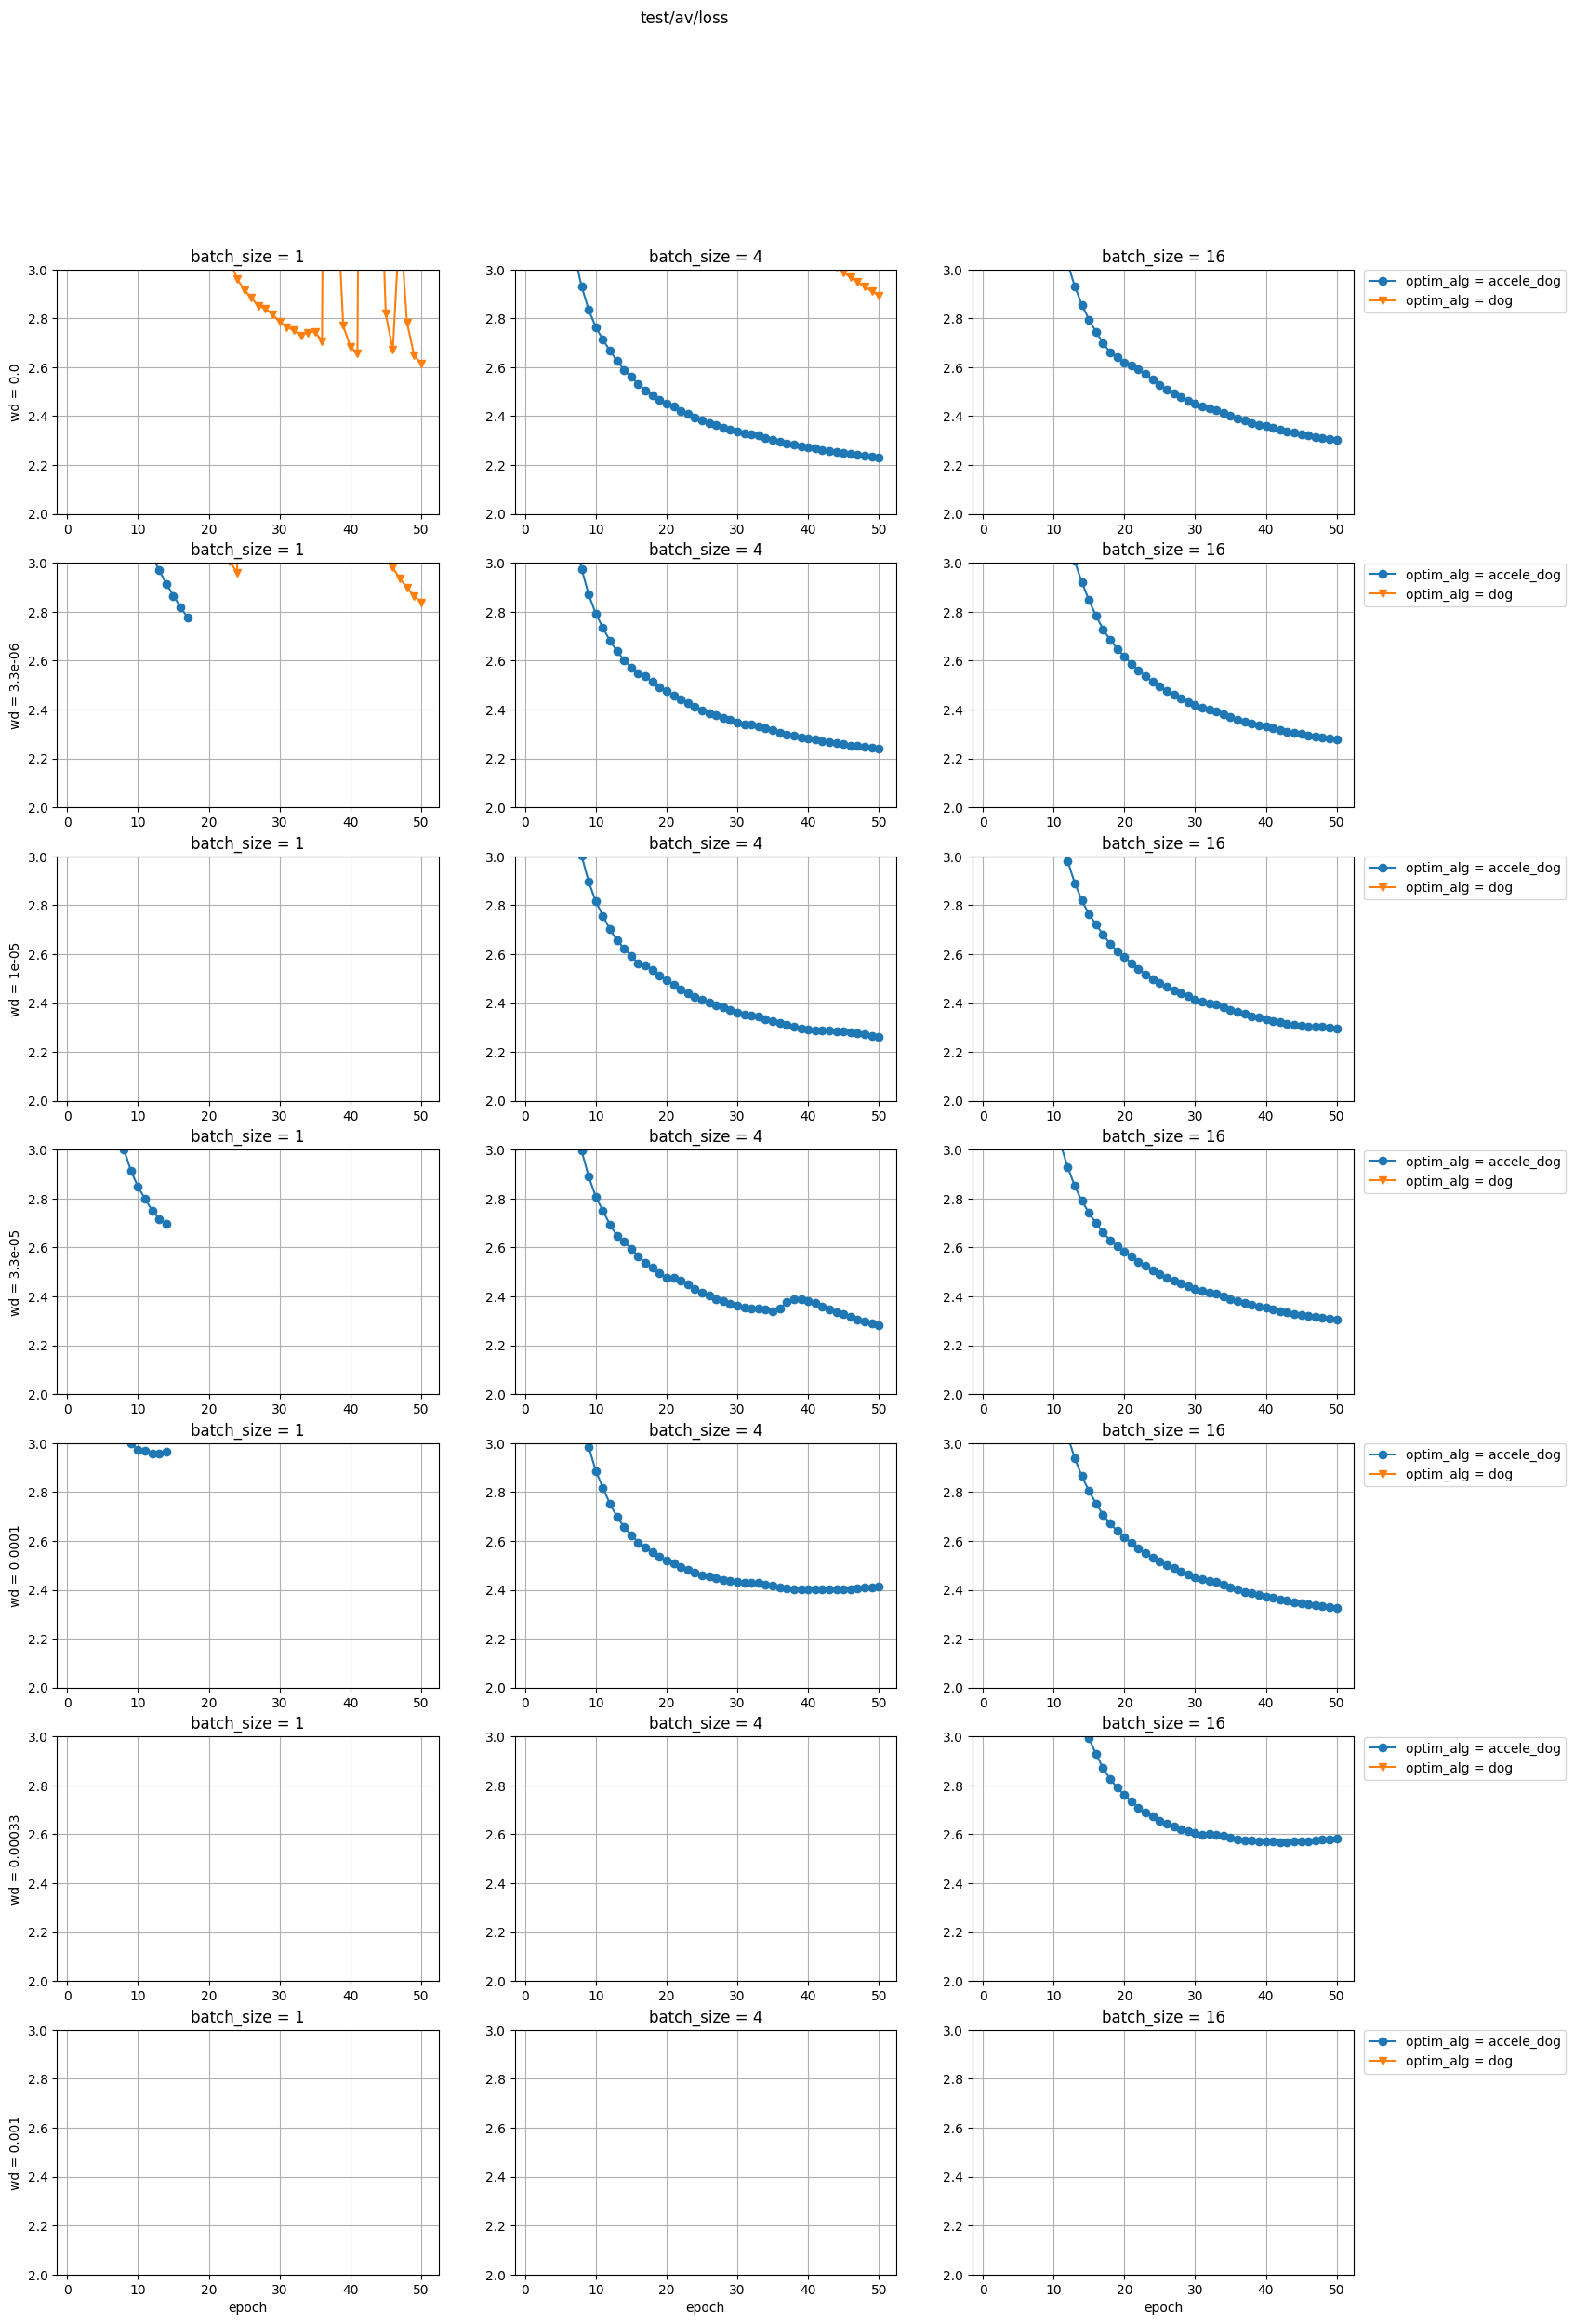

In [44]:
#datasets_to_show = ['vtab/clevr_distance', 'vtab/svhn']
big_df_filt = conv_big_df.query('dog_granularity == "param"')

row_fields = ['wd']
col_fields = ['batch_size']
legend_fields = ['optim_alg']
specific_fields = {}#{'optim_alg': 'dog', 'loss':'log'}
y_field = 'test/av/loss'#'test/constant_8/accuracy' #  'train/rbar' # 'test/last/empirical_subopt' # 'test/last/accuracy' # 'train/empirical_subopt' # 'train/rbar' # 'train/alpha'#'train/eta' # 

big_df_filt = big_df_filt.sort_values(row_fields + col_fields + legend_fields)
n_rows = big_df_filt[row_fields].value_counts().shape[0]
n_cols = big_df_filt[col_fields].value_counts().shape[0]

print (n_rows, n_cols)

base_size = (6,4)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(base_size[0] * n_cols, base_size[1] * n_rows), facecolor='w')
if n_rows * n_cols == 1:
    axes = np.array(axes)
axes = axes.reshape(n_rows, n_cols)

for i_row, (row_vals, row_df) in enumerate(modified_groupby(big_df_filt,row_fields)):
    for i_col, (col_vals, row_col_df) in enumerate(modified_groupby(row_df,col_fields)):
        plt.sca(axes[i_row, i_col])
        for i_entry, (legend_vals, entry_df) in enumerate(modified_groupby(row_col_df,legend_fields)):
            skip = False
            for field in specific_fields:
                idx = legend_fields.index(field)
                skip = skip or not (legend_vals[idx]== specific_fields[field])
            if skip:
                continue
            # we average over repeated entries with the same legend key; a better thing would be to add error bars / shaded region
            plt.plot(sum(entry_df[y_field]) / len(entry_df[y_field]), color=get_color(i_entry), marker=get_marker(i_entry), label=config_str(legend_fields, legend_vals))
        if i_col == 0:
            plt.ylabel(config_str(row_fields, row_vals, sep='\n'))
        if i_col == n_cols - 1:  # assuming elements in the plot are the same for every row
            plt.legend(loc='upper left', bbox_to_anchor=[1.01, 1.025])
        if i_row == n_rows - 1:
            plt.xlabel(entry_df.iloc[0][y_field].index.name)
        if 'subopt' in y_field:
            plt.yscale('log')
            plt.ylim([0.00, 1.0])
        if 'accuracy' in y_field:
            
            #plt.ylim([0.5, 0.8])
            pass

        plt.ylim([2.00, 3.0])
        #plt.yscale('log')

        xlim = plt.xlim()
        if (not (limit is None)) and xlim[1] > limit:
            plt.xlim([-1, limit])
            xlim = plt.xlim()
        
        plt.grid(True, which='major', axis='y')
        plt.grid(True, which='major', axis='x')
        plt.grid(True, which='minor', axis='y', color=[0.9, 0.9, 0.9], linestyle='--')
        plt.title(config_str(col_fields, col_vals))

fig.suptitle(y_field)
#plt.tight_layout()
plt.show()  

In [20]:
get_train_loss_tables(conv_big_df, rows=['optim_alg', 'dog_granularity', 'batch_size'])['layers=6_hidden-dim=224']

0.001000  0.000330  0.000100  0.000033  0.000010  \
accele_dog all   1   5.491682  4.422440  3.055148  2.550897  2.264514   
                 4   4.527851  3.193488  2.528705  2.301513  2.279740   
                 16  3.337649  2.522103  3.588431  2.518590  2.220288   
           param 1   5.308124  4.246840  2.931174  2.728235  3.103329   
                 4   4.297891  3.128270  2.286168  2.144543  2.108844   
                 16  3.559720  2.415038  2.158017  2.126693  2.134416   
dog        all   1   6.675480  5.635588  4.550273  3.553195  3.104748   
                 4   5.726288  4.786458  3.700380  3.267990  2.856594   
                 16  5.301841  4.401111  3.909126  5.242516  4.435579   
           param 1   6.467713  5.526779  4.462782  3.449114  3.378153   
                 4   5.772791  4.835202  3.920025  3.316917  3.597991   
                 16  5.321323  4.354202  3.383817  3.300420  3.235394   

                     0.000003  0.000000  
accele_dog all   1   2.329185  2.370597  
                 4   2.276695  2.330298  
                 16  2.220637  2.662683  
           param 1   2.781556  3.119013  
                 4   2.090038  2.073132  
                 16  2.109080  2.124494  
dog        all   1   2.617458  3.469745  
                 4   2.711321  2.898457  
                 16  4.853563  3.815499  
           param 1   2.715065  2.478534  
                 4   3.800133  2.761442  
                 16  4.076967  4.281245

In [40]:
get_test_loss_tables(conv_big_df, rows=['optim_alg', 'dog_granularity', 'batch_size'])['layers=6_hidden-dim=224']

0.001000  0.000330  0.000100  0.000033  0.000010  \
accele_dog all   1   5.446218  4.489752  3.220911  2.673156  2.441279   
                 4   4.586066  3.369416  2.749278  2.484642  2.467385   
                 16  3.454084  2.727179  3.722441  2.672101  2.399310   
           param 1   5.240702  4.315552  3.084412  2.801590  3.204317   
                 4   4.354991  3.241608  2.499098  2.345488  2.327173   
                 16  3.729010  2.641244  2.386928  2.357372  2.346452   
dog        all   1   6.664739  5.673489  4.667624  3.678270  3.155846   
                 4   5.778864  4.912830  3.859358  3.408533  3.005939   
                 16  5.352131  4.547854  4.063556  5.278525  4.568273   
           param 1   6.493524  5.530115  4.578102  3.585759  3.531774   
                 4   5.857946  4.949730  4.034619  3.474503  3.737374   
                 16  5.345169  4.380098  3.554131  3.458038  3.368279   

                     0.000003  0.000000  
accele_dog all   1   2.506001  2.530954  
                 4   2.450666  2.497459  
                 16  2.403767  2.810305  
           param 1   2.844701  3.253984  
                 4   2.303867  2.293228  
                 16  2.326634  2.352738  
dog        all   1   2.794863  3.382395  
                 4   2.874827  3.044169  
                 16  4.874416  3.971853  
           param 1   2.876251  2.656644  
                 4   3.828293  2.927217  
                 16  4.163637  4.357499

# openhermes adam

In [21]:
conv_adam = read_experiments(['24-05-08-openhermes_adam_betas'
                          ], index_field='epoch', folder='results')

100%|██████████| 64/64 [00:11<00:00,  5.68it/s]


Successfully read 64 out of 64 folders
64 results left after filtering


In [22]:
conv_adam = generate_subopt(conv_adam)

/tmp/ipykernel_3227649/3226964341.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  best_loss = clean_nanmin( df.query(f'loss == "{loss}"').filter(regex='.*/loss').applymap( clean_nanmin ).values )
/tmp/ipykernel_3227649/3226964341.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  best_loss = clean_nanmin( df.filter(regex='.*/loss').applymap( clean_nanmin ).values )


In [33]:
conv_adam = select_av(conv_adam, 'poly_32_1')

In [23]:
by_steps = False
limit = None #7000 #

4 4


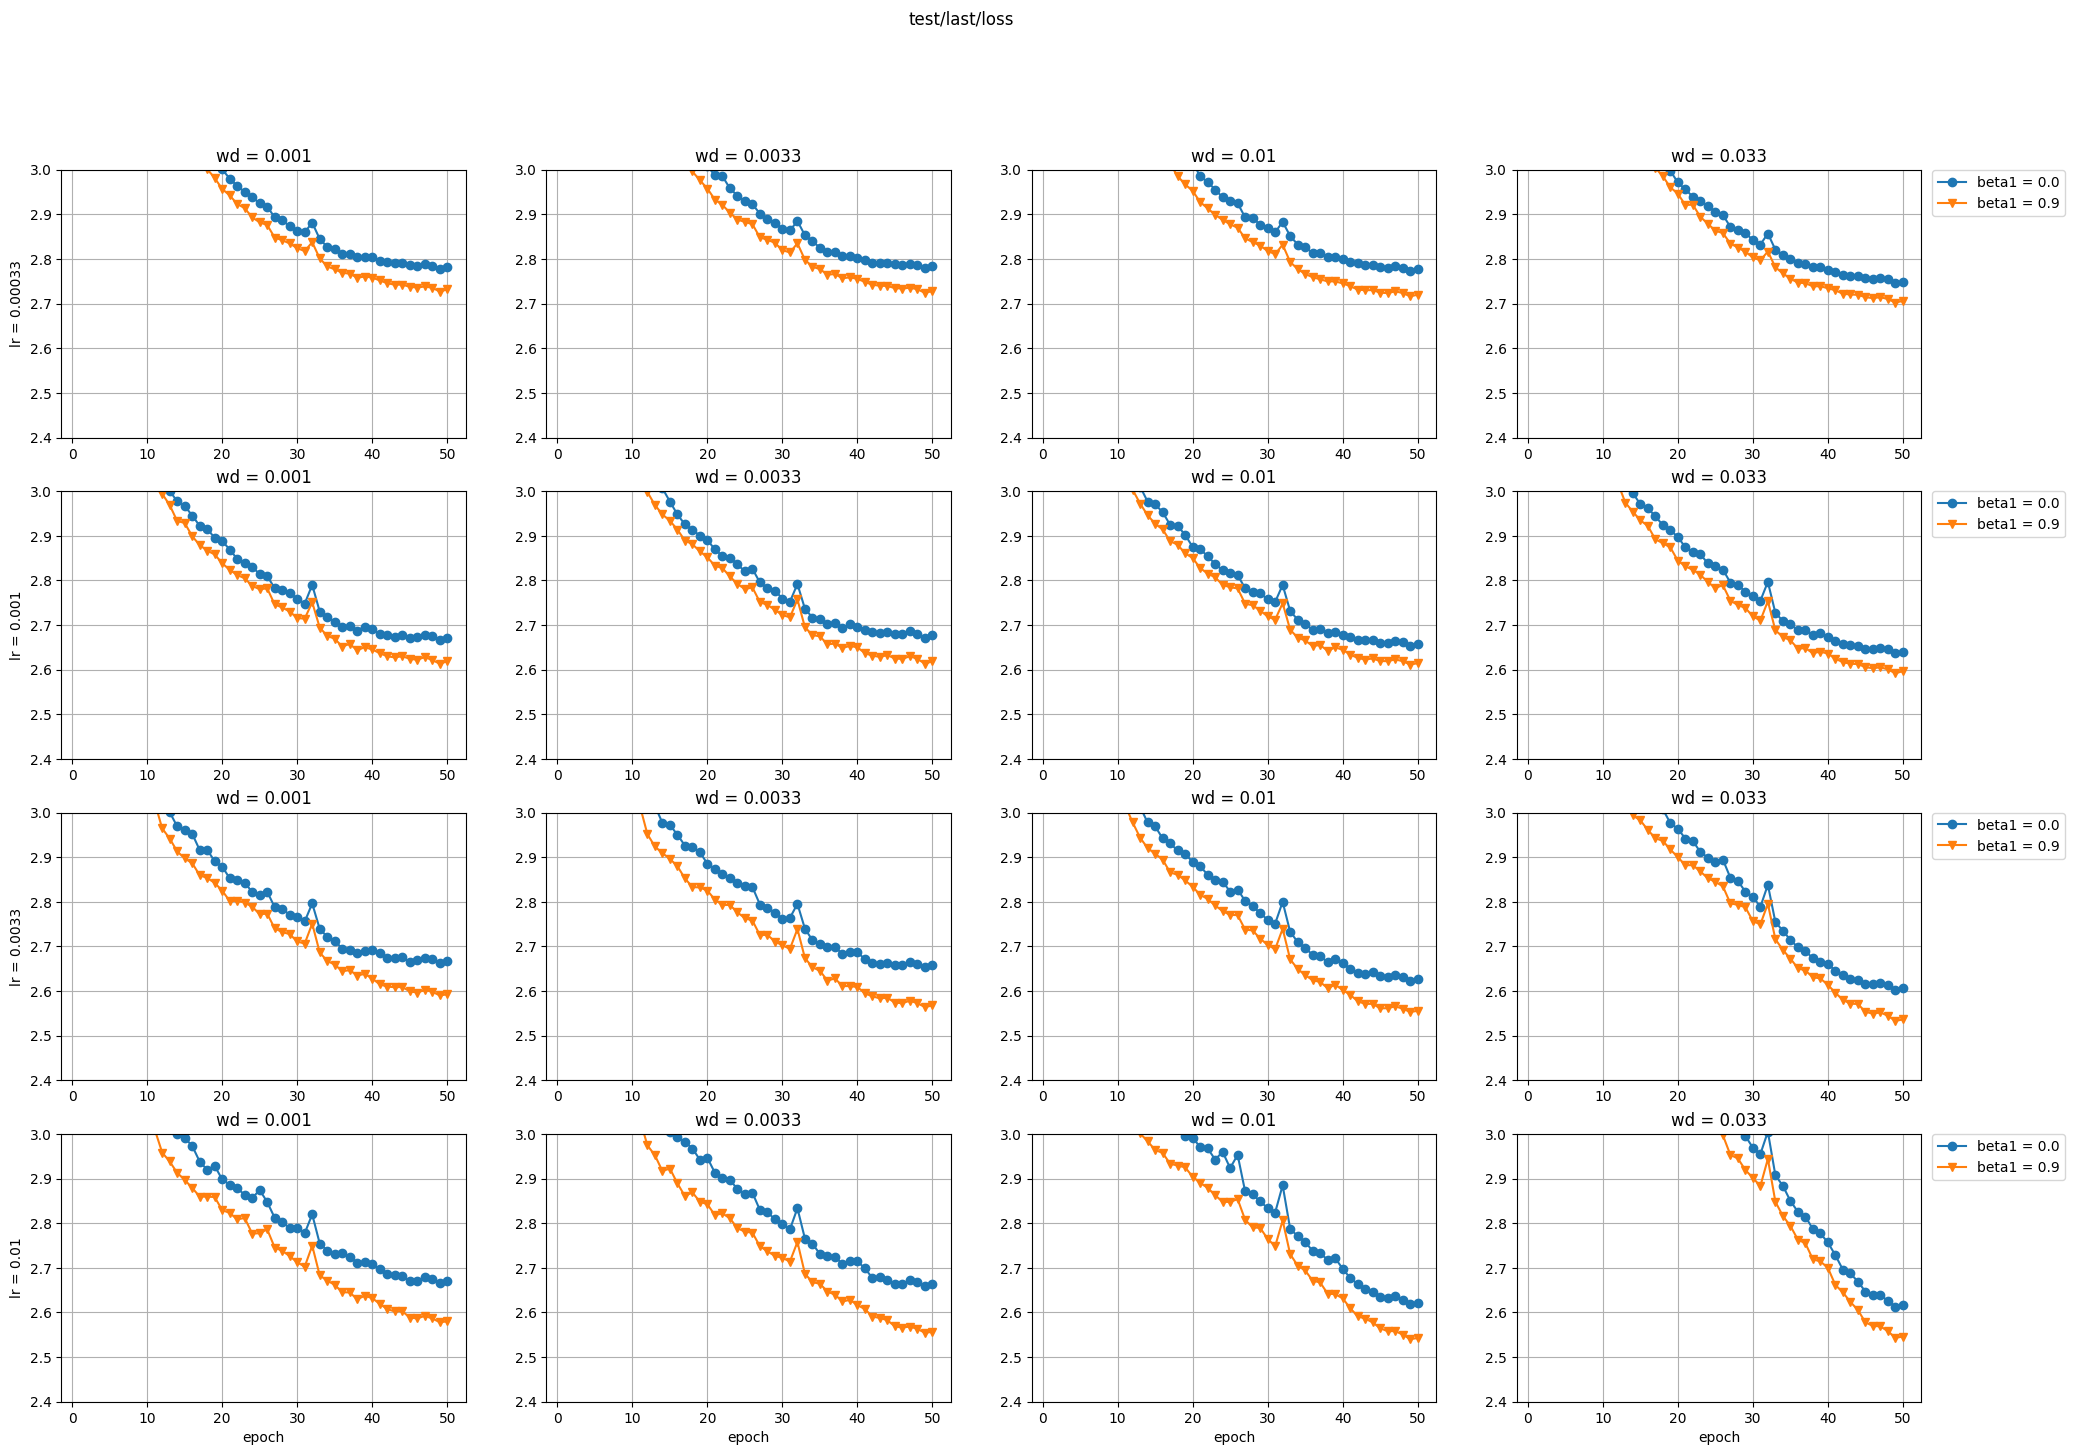

In [42]:
#datasets_to_show = ['vtab/clevr_distance', 'vtab/svhn']
big_df_filt = conv_adam.query('batch_size == 4')

row_fields = ['lr']
col_fields = ['wd']
legend_fields = ['beta1']
specific_fields = {}#{'optim_alg': 'dog', 'loss':'log'}
y_field = 'test/last/loss'#'test/constant_8/accuracy' #  'train/rbar' # 'test/last/empirical_subopt' # 'test/last/accuracy' # 'train/empirical_subopt' # 'train/rbar' # 'train/alpha'#'train/eta' # 

big_df_filt = big_df_filt.sort_values(row_fields + col_fields + legend_fields)
n_rows = big_df_filt[row_fields].value_counts().shape[0]
n_cols = big_df_filt[col_fields].value_counts().shape[0]

print (n_rows, n_cols)

base_size = (6,4)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(base_size[0] * n_cols, base_size[1] * n_rows), facecolor='w')
if n_rows * n_cols == 1:
    axes = np.array(axes)
axes = axes.reshape(n_rows, n_cols)

for i_row, (row_vals, row_df) in enumerate(modified_groupby(big_df_filt,row_fields)):
    for i_col, (col_vals, row_col_df) in enumerate(modified_groupby(row_df,col_fields)):
        plt.sca(axes[i_row, i_col])
        for i_entry, (legend_vals, entry_df) in enumerate(modified_groupby(row_col_df,legend_fields)):
            skip = False
            for field in specific_fields:
                idx = legend_fields.index(field)
                skip = skip or not (legend_vals[idx]== specific_fields[field])
            if skip:
                continue
            # we average over repeated entries with the same legend key; a better thing would be to add error bars / shaded region
            plt.plot(sum(entry_df[y_field]) / len(entry_df[y_field]), color=get_color(i_entry), marker=get_marker(i_entry), label=config_str(legend_fields, legend_vals))
        if i_col == 0:
            plt.ylabel(config_str(row_fields, row_vals, sep='\n'))
        if i_col == n_cols - 1:  # assuming elements in the plot are the same for every row
            plt.legend(loc='upper left', bbox_to_anchor=[1.01, 1.025])
        if i_row == n_rows - 1:
            plt.xlabel(entry_df.iloc[0][y_field].index.name)
        if 'subopt' in y_field:
            plt.yscale('log')
            plt.ylim([0.00, 1.0])
        if 'accuracy' in y_field:
            
            #plt.ylim([0.5, 0.8])
            pass

        plt.ylim([2.40, 3.0])
        #plt.yscale('log')

        xlim = plt.xlim()
        if (not (limit is None)) and xlim[1] > limit:
            plt.xlim([-1, limit])
            xlim = plt.xlim()
        
        plt.grid(True, which='major', axis='y')
        plt.grid(True, which='major', axis='x')
        plt.grid(True, which='minor', axis='y', color=[0.9, 0.9, 0.9], linestyle='--')
        plt.title(config_str(col_fields, col_vals))

fig.suptitle(y_field)
#plt.tight_layout()
plt.show()  

In [29]:
get_train_loss_tables(conv_adam.query('batch_size == 4'), rows=['lr', 'beta1'])['layers=6_hidden-dim=224']

0.0330    0.0100    0.0033    0.0010
0.00033 0.0  2.567526  2.594490  2.603712  2.585435
        0.9  2.522611  2.525820  2.536640  2.529518
0.00100 0.0  2.443405  2.456249  2.481490  2.478481
        0.9  2.407258  2.404358  2.411570  2.396265
0.00330 0.0  2.407862  2.424322  2.450531  2.471944
        0.9  2.336972  2.348860  2.371005  2.395317
0.01000 0.0  2.429410  2.415018  2.452242  2.456311
        0.9  2.371153  2.364102  2.360321  2.368302

In [45]:
get_test_loss_tables(conv_adam, rows=['lr', 'beta1', 'batch_size'])['layers=6_hidden-dim=224']

0.0330    0.0100    0.0033    0.0010
0.00033 0.0 1  3.154569  3.168022  3.187365  3.199577
            4  2.746601  2.773579  2.780433  2.778180
        0.9 1  3.062370  3.094926  3.108840  3.112660
            4  2.702515  2.716406  2.723979  2.727111
0.00100 0.0 1  3.089713  3.102473  3.143345  3.155495
            4  2.636898  2.652261  2.670116  2.666095
        0.9 1  3.019400  3.038747  3.057597  3.073916
            4  2.592015  2.611194  2.614161  2.613317
0.00330 0.0 1  3.070907  3.088964  3.108902  3.135277
            4  2.603375  2.622504  2.653716  2.663244
        0.9 1  3.025849  2.995002  3.060633  3.062705
            4  2.534762  2.553163  2.564150  2.590143
0.01000 0.0 1  3.181723  3.114254  3.125679  3.160526
            4  2.612723  2.618603  2.659480  2.666718
        0.9 1  3.087193  3.052414  3.062550  3.089713
            4  2.543241  2.540152  2.554366  2.578097